## Imports

In [4]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [5]:
RANDOM_SEED = 1
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
NUM_EPOCHS = 20

RESOLUTION = 200
NUM_FEATURES = RESOLUTION*RESOLUTION
NUM_CLASSES = 66

DEVICE = "cuda:0"
GRAYSCALE = False

In [7]:
transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor()
])

path = 'CV_data/dataset_augmented'
dataset = datasets.ImageFolder(root=path, transform=transform)


# Get class to index mapping
class_to_idx = dataset.class_to_idx

# Define index to class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training set and test set
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)


In [8]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Labels:', labels)
    break


Image batch dimensions: torch.Size([32, 3, 200, 200])
Image label dimensions: torch.Size([32])
Labels: tensor([58, 34, 19, 32, 38, 56, 63, 38, 28, 49, 58, 30, 36, 24, 19, 31, 44, 18,
        29, 48, 47, 56, 62, 15, 50, 35, 17, 59, 10, 62, 27, 62])


In [9]:
from collections import Counter


train_classes = [dataset.targets[i] for i in train_dataset.indices]
class_weights = 1 / torch.tensor(list(dict(sorted(dict(Counter(train_classes)).items())).values()))
class_weights

tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005])

In [10]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 32
Epoch: 2 | Batch index: 0 | Batch size: 32


# Model

In [11]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [12]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [13]:
def compute_accuracy(model, data_loader, device, mode="train"):
    correct_pred, num_examples = 0, 0
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
        if not batch_idx % 50:
            accuracy = correct_pred.float() / num_examples * 100
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-accuracy.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {accuracy}\n")
            correct_pred, num_examples = 0, 0



In [14]:
def compute_loss(model, data_loader, class_weights, device, mode="val"):
    losses = []
    dataset_len = len(data_loader)
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        class_weights = class_weights.to(DEVICE)
            
        logits, _ = model(features)
        loss = F.cross_entropy(logits, targets, weight=class_weights)
        losses.append(loss)
        
        if not batch_idx % 50:
            mean_loss = sum(losses) / len(losses)
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-loss.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
            losses.clear()

In [15]:
model_name = "07-model"

## Training

In [ ]:

start_time = time.time()

for epoch in range(NUM_EPOCHS):
        model.train()
        losses = []
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            class_weights = class_weights.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, weight=class_weights)
            losses.append(loss)

            optimizer.zero_grad()

            loss.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx,
                         len(train_loader), loss))

                mean_loss = sum(losses) / len(losses)
                with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-train-loss.csv', 'a') as fp:
                    fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
                losses.clear()


        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference
            compute_accuracy(model, train_loader, device=DEVICE, mode="train")
            compute_loss(model, val_loader, class_weights, device=DEVICE, mode="val")
            compute_accuracy(model, val_loader, device=DEVICE, mode="val")

        file_path = f'CV_data/models/{model_name}-{LEARNING_RATE}-epoch{epoch+1}.pth'
        torch.save(model.state_dict(), file_path)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/4332 | Cost: 4.1036
Epoch: 001/020 | Batch 0050/4332 | Cost: 4.2327
Epoch: 001/020 | Batch 0100/4332 | Cost: 3.8923
Epoch: 001/020 | Batch 0150/4332 | Cost: 3.5882
Epoch: 001/020 | Batch 0200/4332 | Cost: 3.5244
Epoch: 001/020 | Batch 0250/4332 | Cost: 3.2740
Epoch: 001/020 | Batch 0300/4332 | Cost: 3.1442
Epoch: 001/020 | Batch 0350/4332 | Cost: 3.1725
Epoch: 001/020 | Batch 0400/4332 | Cost: 2.8073
Epoch: 001/020 | Batch 0450/4332 | Cost: 2.7082
Epoch: 001/020 | Batch 0500/4332 | Cost: 2.6139
Epoch: 001/020 | Batch 0550/4332 | Cost: 2.7529
Epoch: 001/020 | Batch 0600/4332 | Cost: 2.7639
Epoch: 001/020 | Batch 0650/4332 | Cost: 2.4043
Epoch: 001/020 | Batch 0700/4332 | Cost: 2.4888
Epoch: 001/020 | Batch 0750/4332 | Cost: 2.6366
Epoch: 001/020 | Batch 0800/4332 | Cost: 2.3841
Epoch: 001/020 | Batch 0850/4332 | Cost: 2.0368
Epoch: 001/020 | Batch 0900/4332 | Cost: 1.8986
Epoch: 001/020 | Batch 0950/4332 | Cost: 2.1039
Epoch: 001/020 | Batch 1000/4332 | Cost:

4332it [06:46, 10.66it/s]
1444it [02:32,  9.46it/s]
1444it [02:23, 10.08it/s]


Time elapsed: 20.77 min
Epoch: 002/020 | Batch 0000/4332 | Cost: 0.8568
Epoch: 002/020 | Batch 0050/4332 | Cost: 1.2203
Epoch: 002/020 | Batch 0100/4332 | Cost: 1.3525
Epoch: 002/020 | Batch 0150/4332 | Cost: 1.0080
Epoch: 002/020 | Batch 0200/4332 | Cost: 0.8247
Epoch: 002/020 | Batch 0250/4332 | Cost: 1.1064
Epoch: 002/020 | Batch 0300/4332 | Cost: 0.6765
Epoch: 002/020 | Batch 0350/4332 | Cost: 0.9534
Epoch: 002/020 | Batch 0400/4332 | Cost: 0.8103
Epoch: 002/020 | Batch 0450/4332 | Cost: 1.4559
Epoch: 002/020 | Batch 0500/4332 | Cost: 1.1001
Epoch: 002/020 | Batch 0550/4332 | Cost: 0.7691
Epoch: 002/020 | Batch 0600/4332 | Cost: 1.2065
Epoch: 002/020 | Batch 0650/4332 | Cost: 0.7404
Epoch: 002/020 | Batch 0700/4332 | Cost: 0.5724
Epoch: 002/020 | Batch 0750/4332 | Cost: 1.1894
Epoch: 002/020 | Batch 0800/4332 | Cost: 1.2675
Epoch: 002/020 | Batch 0850/4332 | Cost: 0.6254
Epoch: 002/020 | Batch 0900/4332 | Cost: 0.8320
Epoch: 002/020 | Batch 0950/4332 | Cost: 0.5728
Epoch: 002/020 |

4332it [07:01, 10.27it/s]
1444it [02:25,  9.92it/s]
1444it [02:18, 10.43it/s]


Time elapsed: 40.97 min
Epoch: 003/020 | Batch 0000/4332 | Cost: 0.4515
Epoch: 003/020 | Batch 0050/4332 | Cost: 0.8283
Epoch: 003/020 | Batch 0100/4332 | Cost: 0.9940
Epoch: 003/020 | Batch 0150/4332 | Cost: 0.4582
Epoch: 003/020 | Batch 0200/4332 | Cost: 0.6995
Epoch: 003/020 | Batch 0250/4332 | Cost: 0.3454
Epoch: 003/020 | Batch 0300/4332 | Cost: 0.4859
Epoch: 003/020 | Batch 0350/4332 | Cost: 0.5748
Epoch: 003/020 | Batch 0400/4332 | Cost: 0.4049
Epoch: 003/020 | Batch 0450/4332 | Cost: 0.4400
Epoch: 003/020 | Batch 0500/4332 | Cost: 0.7677
Epoch: 003/020 | Batch 0550/4332 | Cost: 0.4725
Epoch: 003/020 | Batch 0600/4332 | Cost: 0.2700
Epoch: 003/020 | Batch 0650/4332 | Cost: 0.6147
Epoch: 003/020 | Batch 0700/4332 | Cost: 0.5665
Epoch: 003/020 | Batch 0750/4332 | Cost: 0.5701
Epoch: 003/020 | Batch 0800/4332 | Cost: 0.4794
Epoch: 003/020 | Batch 0850/4332 | Cost: 0.7595
Epoch: 003/020 | Batch 0900/4332 | Cost: 0.8408
Epoch: 003/020 | Batch 0950/4332 | Cost: 0.6445
Epoch: 003/020 |

4332it [07:35,  9.50it/s]
1444it [02:23, 10.05it/s]
1444it [02:21, 10.22it/s]


Time elapsed: 61.58 min
Epoch: 004/020 | Batch 0000/4332 | Cost: 0.3678
Epoch: 004/020 | Batch 0050/4332 | Cost: 0.4127
Epoch: 004/020 | Batch 0100/4332 | Cost: 0.2191
Epoch: 004/020 | Batch 0150/4332 | Cost: 0.5111
Epoch: 004/020 | Batch 0200/4332 | Cost: 0.3451
Epoch: 004/020 | Batch 0250/4332 | Cost: 0.5502
Epoch: 004/020 | Batch 0300/4332 | Cost: 0.4879
Epoch: 004/020 | Batch 0350/4332 | Cost: 0.3678
Epoch: 004/020 | Batch 0400/4332 | Cost: 0.5359
Epoch: 004/020 | Batch 0450/4332 | Cost: 0.4027
Epoch: 004/020 | Batch 0500/4332 | Cost: 0.5952
Epoch: 004/020 | Batch 0550/4332 | Cost: 0.5686
Epoch: 004/020 | Batch 0600/4332 | Cost: 0.3170
Epoch: 004/020 | Batch 0650/4332 | Cost: 0.6989
Epoch: 004/020 | Batch 0700/4332 | Cost: 0.2893
Epoch: 004/020 | Batch 0750/4332 | Cost: 0.4333
Epoch: 004/020 | Batch 0800/4332 | Cost: 1.1686
Epoch: 004/020 | Batch 0850/4332 | Cost: 0.8793
Epoch: 004/020 | Batch 0900/4332 | Cost: 0.2218
Epoch: 004/020 | Batch 0950/4332 | Cost: 0.2237
Epoch: 004/020 |

4332it [08:31,  8.47it/s]
1444it [02:46,  8.67it/s]
1444it [02:48,  8.56it/s]


Time elapsed: 85.58 min
Epoch: 005/020 | Batch 0000/4332 | Cost: 0.5523
Epoch: 005/020 | Batch 0050/4332 | Cost: 0.4587
Epoch: 005/020 | Batch 0100/4332 | Cost: 0.5538
Epoch: 005/020 | Batch 0150/4332 | Cost: 0.2089
Epoch: 005/020 | Batch 0200/4332 | Cost: 0.5084
Epoch: 005/020 | Batch 0250/4332 | Cost: 0.4781
Epoch: 005/020 | Batch 0300/4332 | Cost: 0.4178
Epoch: 005/020 | Batch 0350/4332 | Cost: 0.1566
Epoch: 005/020 | Batch 0400/4332 | Cost: 0.3010
Epoch: 005/020 | Batch 0450/4332 | Cost: 0.3167
Epoch: 005/020 | Batch 0500/4332 | Cost: 0.4706
Epoch: 005/020 | Batch 0550/4332 | Cost: 0.0947
Epoch: 005/020 | Batch 0600/4332 | Cost: 0.3075
Epoch: 005/020 | Batch 0650/4332 | Cost: 0.1952
Epoch: 005/020 | Batch 0700/4332 | Cost: 0.4329
Epoch: 005/020 | Batch 0750/4332 | Cost: 0.1196
Epoch: 005/020 | Batch 0800/4332 | Cost: 0.1875
Epoch: 005/020 | Batch 0850/4332 | Cost: 0.5298
Epoch: 005/020 | Batch 0900/4332 | Cost: 0.2212
Epoch: 005/020 | Batch 0950/4332 | Cost: 0.4836
Epoch: 005/020 |

4332it [08:33,  8.44it/s]
1444it [02:46,  8.68it/s]
1444it [02:34,  9.32it/s]


Time elapsed: 108.85 min
Epoch: 006/020 | Batch 0000/4332 | Cost: 0.1171
Epoch: 006/020 | Batch 0050/4332 | Cost: 0.2487
Epoch: 006/020 | Batch 0100/4332 | Cost: 0.2378
Epoch: 006/020 | Batch 0150/4332 | Cost: 0.2630
Epoch: 006/020 | Batch 0200/4332 | Cost: 0.2084
Epoch: 006/020 | Batch 0250/4332 | Cost: 0.1917
Epoch: 006/020 | Batch 0300/4332 | Cost: 0.3900
Epoch: 006/020 | Batch 0350/4332 | Cost: 0.4469
Epoch: 006/020 | Batch 0400/4332 | Cost: 0.2078
Epoch: 006/020 | Batch 0450/4332 | Cost: 0.1586
Epoch: 006/020 | Batch 0500/4332 | Cost: 0.1397
Epoch: 006/020 | Batch 0550/4332 | Cost: 0.1596
Epoch: 006/020 | Batch 0600/4332 | Cost: 0.6450
Epoch: 006/020 | Batch 0650/4332 | Cost: 0.2266
Epoch: 006/020 | Batch 0700/4332 | Cost: 0.2062
Epoch: 006/020 | Batch 0750/4332 | Cost: 0.1278
Epoch: 006/020 | Batch 0800/4332 | Cost: 0.2344
Epoch: 006/020 | Batch 0850/4332 | Cost: 0.3292
Epoch: 006/020 | Batch 0900/4332 | Cost: 0.2093
Epoch: 006/020 | Batch 0950/4332 | Cost: 0.1999
Epoch: 006/020 

4332it [06:53, 10.48it/s]
1444it [02:18, 10.45it/s]
1444it [02:18, 10.45it/s]


Time elapsed: 128.59 min
Epoch: 007/020 | Batch 0000/4332 | Cost: 0.2420
Epoch: 007/020 | Batch 0050/4332 | Cost: 0.2267
Epoch: 007/020 | Batch 0100/4332 | Cost: 0.2169
Epoch: 007/020 | Batch 0150/4332 | Cost: 0.3356
Epoch: 007/020 | Batch 0200/4332 | Cost: 0.0948
Epoch: 007/020 | Batch 0250/4332 | Cost: 0.1460
Epoch: 007/020 | Batch 0300/4332 | Cost: 0.4510
Epoch: 007/020 | Batch 0350/4332 | Cost: 0.2802
Epoch: 007/020 | Batch 0400/4332 | Cost: 0.1358
Epoch: 007/020 | Batch 0450/4332 | Cost: 0.3595
Epoch: 007/020 | Batch 0500/4332 | Cost: 0.1656
Epoch: 007/020 | Batch 0550/4332 | Cost: 0.1562
Epoch: 007/020 | Batch 0600/4332 | Cost: 0.2427
Epoch: 007/020 | Batch 0650/4332 | Cost: 0.3612
Epoch: 007/020 | Batch 0700/4332 | Cost: 0.2660
Epoch: 007/020 | Batch 0750/4332 | Cost: 0.1705
Epoch: 007/020 | Batch 0800/4332 | Cost: 0.1731
Epoch: 007/020 | Batch 0850/4332 | Cost: 0.0887
Epoch: 007/020 | Batch 0900/4332 | Cost: 0.0969
Epoch: 007/020 | Batch 0950/4332 | Cost: 0.3290
Epoch: 007/020 

4332it [06:37, 10.91it/s]
1444it [02:36,  9.21it/s]
1444it [02:10, 11.06it/s]


Time elapsed: 148.12 min
Epoch: 008/020 | Batch 0000/4332 | Cost: 0.0981
Epoch: 008/020 | Batch 0050/4332 | Cost: 0.0714
Epoch: 008/020 | Batch 0100/4332 | Cost: 0.2036
Epoch: 008/020 | Batch 0150/4332 | Cost: 0.3508
Epoch: 008/020 | Batch 0200/4332 | Cost: 0.1269
Epoch: 008/020 | Batch 0250/4332 | Cost: 0.2223
Epoch: 008/020 | Batch 0300/4332 | Cost: 0.2958
Epoch: 008/020 | Batch 0350/4332 | Cost: 0.1201
Epoch: 008/020 | Batch 0400/4332 | Cost: 0.1804
Epoch: 008/020 | Batch 0450/4332 | Cost: 0.1326
Epoch: 008/020 | Batch 0500/4332 | Cost: 0.1520
Epoch: 008/020 | Batch 0550/4332 | Cost: 0.0863
Epoch: 008/020 | Batch 0600/4332 | Cost: 0.1362
Epoch: 008/020 | Batch 0650/4332 | Cost: 0.1118
Epoch: 008/020 | Batch 0700/4332 | Cost: 0.3585
Epoch: 008/020 | Batch 0750/4332 | Cost: 0.0543
Epoch: 008/020 | Batch 0800/4332 | Cost: 0.0673
Epoch: 008/020 | Batch 0850/4332 | Cost: 0.0759
Epoch: 008/020 | Batch 0900/4332 | Cost: 0.2004
Epoch: 008/020 | Batch 0950/4332 | Cost: 0.1506
Epoch: 008/020 

4332it [08:18,  8.69it/s]
1444it [02:36,  9.26it/s]
1444it [02:16, 10.61it/s]


Time elapsed: 169.19 min
Epoch: 009/020 | Batch 0000/4332 | Cost: 0.0494
Epoch: 009/020 | Batch 0050/4332 | Cost: 0.1343
Epoch: 009/020 | Batch 0100/4332 | Cost: 0.0785
Epoch: 009/020 | Batch 0150/4332 | Cost: 0.0771
Epoch: 009/020 | Batch 0200/4332 | Cost: 0.0601
Epoch: 009/020 | Batch 0250/4332 | Cost: 0.2414
Epoch: 009/020 | Batch 0300/4332 | Cost: 0.1211
Epoch: 009/020 | Batch 0350/4332 | Cost: 0.1487
Epoch: 009/020 | Batch 0400/4332 | Cost: 0.0624
Epoch: 009/020 | Batch 0450/4332 | Cost: 0.0968
Epoch: 009/020 | Batch 0500/4332 | Cost: 0.1369
Epoch: 009/020 | Batch 0550/4332 | Cost: 0.1750
Epoch: 009/020 | Batch 0600/4332 | Cost: 0.1385
Epoch: 009/020 | Batch 0650/4332 | Cost: 0.1260
Epoch: 009/020 | Batch 0700/4332 | Cost: 0.1467
Epoch: 009/020 | Batch 0750/4332 | Cost: 0.1430
Epoch: 009/020 | Batch 0800/4332 | Cost: 0.3310
Epoch: 009/020 | Batch 0850/4332 | Cost: 0.0895
Epoch: 009/020 | Batch 0900/4332 | Cost: 0.1080
Epoch: 009/020 | Batch 0950/4332 | Cost: 0.1567
Epoch: 009/020 

4332it [06:30, 11.09it/s]
1444it [02:09, 11.17it/s]
1444it [02:12, 10.91it/s]


Time elapsed: 187.83 min
Epoch: 010/020 | Batch 0000/4332 | Cost: 0.1586
Epoch: 010/020 | Batch 0050/4332 | Cost: 0.1086
Epoch: 010/020 | Batch 0100/4332 | Cost: 0.0387
Epoch: 010/020 | Batch 0150/4332 | Cost: 0.0832
Epoch: 010/020 | Batch 0200/4332 | Cost: 0.0986
Epoch: 010/020 | Batch 0250/4332 | Cost: 0.2658
Epoch: 010/020 | Batch 0300/4332 | Cost: 0.0701
Epoch: 010/020 | Batch 0350/4332 | Cost: 0.1072
Epoch: 010/020 | Batch 0400/4332 | Cost: 0.1799
Epoch: 010/020 | Batch 0450/4332 | Cost: 0.1031
Epoch: 010/020 | Batch 0500/4332 | Cost: 0.1603
Epoch: 010/020 | Batch 0550/4332 | Cost: 0.2978
Epoch: 010/020 | Batch 0600/4332 | Cost: 0.0268
Epoch: 010/020 | Batch 0650/4332 | Cost: 0.0557
Epoch: 010/020 | Batch 0700/4332 | Cost: 0.2511
Epoch: 010/020 | Batch 0750/4332 | Cost: 0.2236
Epoch: 010/020 | Batch 0800/4332 | Cost: 0.1258
Epoch: 010/020 | Batch 0850/4332 | Cost: 0.3051
Epoch: 010/020 | Batch 0900/4332 | Cost: 0.0555
Epoch: 010/020 | Batch 0950/4332 | Cost: 0.2421
Epoch: 010/020 

4332it [06:42, 10.77it/s]
1444it [02:15, 10.62it/s]
1444it [02:16, 10.61it/s]


Time elapsed: 206.83 min
Epoch: 011/020 | Batch 0000/4332 | Cost: 0.1535
Epoch: 011/020 | Batch 0050/4332 | Cost: 0.0479
Epoch: 011/020 | Batch 0100/4332 | Cost: 0.0668
Epoch: 011/020 | Batch 0150/4332 | Cost: 0.1117
Epoch: 011/020 | Batch 0200/4332 | Cost: 0.0974
Epoch: 011/020 | Batch 0250/4332 | Cost: 0.0207
Epoch: 011/020 | Batch 0300/4332 | Cost: 0.0359
Epoch: 011/020 | Batch 0350/4332 | Cost: 0.0262
Epoch: 011/020 | Batch 0400/4332 | Cost: 0.0927
Epoch: 011/020 | Batch 0450/4332 | Cost: 0.0532
Epoch: 011/020 | Batch 0500/4332 | Cost: 0.1198
Epoch: 011/020 | Batch 0550/4332 | Cost: 0.0859
Epoch: 011/020 | Batch 0600/4332 | Cost: 0.2368
Epoch: 011/020 | Batch 0650/4332 | Cost: 0.1287
Epoch: 011/020 | Batch 0700/4332 | Cost: 0.1688
Epoch: 011/020 | Batch 0750/4332 | Cost: 0.0757
Epoch: 011/020 | Batch 0800/4332 | Cost: 0.1465
Epoch: 011/020 | Batch 0850/4332 | Cost: 0.0983
Epoch: 011/020 | Batch 0900/4332 | Cost: 0.1004
Epoch: 011/020 | Batch 0950/4332 | Cost: 0.0934
Epoch: 011/020 

4332it [06:47, 10.63it/s]
1444it [02:16, 10.54it/s]
1444it [02:13, 10.82it/s]


Time elapsed: 226.09 min
Epoch: 012/020 | Batch 0000/4332 | Cost: 0.0315
Epoch: 012/020 | Batch 0050/4332 | Cost: 0.0742
Epoch: 012/020 | Batch 0100/4332 | Cost: 0.1054
Epoch: 012/020 | Batch 0150/4332 | Cost: 0.0804
Epoch: 012/020 | Batch 0200/4332 | Cost: 0.0993
Epoch: 012/020 | Batch 0250/4332 | Cost: 0.0613
Epoch: 012/020 | Batch 0300/4332 | Cost: 0.0852
Epoch: 012/020 | Batch 0350/4332 | Cost: 0.0359
Epoch: 012/020 | Batch 0400/4332 | Cost: 0.1751
Epoch: 012/020 | Batch 0450/4332 | Cost: 0.0882
Epoch: 012/020 | Batch 0500/4332 | Cost: 0.3872
Epoch: 012/020 | Batch 0550/4332 | Cost: 0.0278
Epoch: 012/020 | Batch 0600/4332 | Cost: 0.0905
Epoch: 012/020 | Batch 0650/4332 | Cost: 0.1807
Epoch: 012/020 | Batch 0700/4332 | Cost: 0.0586
Epoch: 012/020 | Batch 0750/4332 | Cost: 0.0387
Epoch: 012/020 | Batch 0800/4332 | Cost: 0.0647
Epoch: 012/020 | Batch 0850/4332 | Cost: 0.0458
Epoch: 012/020 | Batch 0900/4332 | Cost: 0.0643
Epoch: 012/020 | Batch 0950/4332 | Cost: 0.0611
Epoch: 012/020 

4332it [06:49, 10.58it/s]
1444it [02:17, 10.47it/s]
1444it [02:17, 10.52it/s]


Time elapsed: 245.43 min
Epoch: 013/020 | Batch 0000/4332 | Cost: 0.0261
Epoch: 013/020 | Batch 0050/4332 | Cost: 0.0400
Epoch: 013/020 | Batch 0100/4332 | Cost: 0.0984
Epoch: 013/020 | Batch 0150/4332 | Cost: 0.1186
Epoch: 013/020 | Batch 0200/4332 | Cost: 0.0162
Epoch: 013/020 | Batch 0250/4332 | Cost: 0.1166
Epoch: 013/020 | Batch 0300/4332 | Cost: 0.0319
Epoch: 013/020 | Batch 0350/4332 | Cost: 0.1705
Epoch: 013/020 | Batch 0400/4332 | Cost: 0.1103
Epoch: 013/020 | Batch 0450/4332 | Cost: 0.0461
Epoch: 013/020 | Batch 0500/4332 | Cost: 0.0657
Epoch: 013/020 | Batch 0550/4332 | Cost: 0.0267
Epoch: 013/020 | Batch 0600/4332 | Cost: 0.0137
Epoch: 013/020 | Batch 0650/4332 | Cost: 0.0146
Epoch: 013/020 | Batch 0700/4332 | Cost: 0.0349
Epoch: 013/020 | Batch 0750/4332 | Cost: 0.1485
Epoch: 013/020 | Batch 0800/4332 | Cost: 0.0464
Epoch: 013/020 | Batch 0850/4332 | Cost: 0.0628
Epoch: 013/020 | Batch 0900/4332 | Cost: 0.0254
Epoch: 013/020 | Batch 0950/4332 | Cost: 0.0302
Epoch: 013/020 

4332it [06:44, 10.71it/s]
1444it [02:15, 10.67it/s]
1444it [02:14, 10.71it/s]


Time elapsed: 264.69 min
Epoch: 014/020 | Batch 0000/4332 | Cost: 0.0977
Epoch: 014/020 | Batch 0050/4332 | Cost: 0.2123
Epoch: 014/020 | Batch 0100/4332 | Cost: 0.0780
Epoch: 014/020 | Batch 0150/4332 | Cost: 0.0235
Epoch: 014/020 | Batch 0200/4332 | Cost: 0.0990
Epoch: 014/020 | Batch 0250/4332 | Cost: 0.0666
Epoch: 014/020 | Batch 0300/4332 | Cost: 0.0413
Epoch: 014/020 | Batch 0350/4332 | Cost: 0.0252
Epoch: 014/020 | Batch 0400/4332 | Cost: 0.0378
Epoch: 014/020 | Batch 0450/4332 | Cost: 0.1454
Epoch: 014/020 | Batch 0500/4332 | Cost: 0.0851
Epoch: 014/020 | Batch 0550/4332 | Cost: 0.0292
Epoch: 014/020 | Batch 0600/4332 | Cost: 0.1143
Epoch: 014/020 | Batch 0650/4332 | Cost: 0.0475
Epoch: 014/020 | Batch 0700/4332 | Cost: 0.0314
Epoch: 014/020 | Batch 0750/4332 | Cost: 0.1105
Epoch: 014/020 | Batch 0800/4332 | Cost: 0.0438
Epoch: 014/020 | Batch 0850/4332 | Cost: 0.0208
Epoch: 014/020 | Batch 0900/4332 | Cost: 0.0213
Epoch: 014/020 | Batch 0950/4332 | Cost: 0.0346
Epoch: 014/020 

4332it [06:23, 11.28it/s]
1444it [02:07, 11.33it/s]
1444it [02:07, 11.29it/s]


Time elapsed: 283.17 min
Epoch: 015/020 | Batch 0000/4332 | Cost: 0.0291
Epoch: 015/020 | Batch 0050/4332 | Cost: 0.0688
Epoch: 015/020 | Batch 0100/4332 | Cost: 0.1287
Epoch: 015/020 | Batch 0150/4332 | Cost: 0.0317
Epoch: 015/020 | Batch 0200/4332 | Cost: 0.0201
Epoch: 015/020 | Batch 0250/4332 | Cost: 0.0380
Epoch: 015/020 | Batch 0300/4332 | Cost: 0.1468
Epoch: 015/020 | Batch 0350/4332 | Cost: 0.1519
Epoch: 015/020 | Batch 0400/4332 | Cost: 0.1888
Epoch: 015/020 | Batch 0450/4332 | Cost: 0.0608
Epoch: 015/020 | Batch 0500/4332 | Cost: 0.0472
Epoch: 015/020 | Batch 0550/4332 | Cost: 0.0078
Epoch: 015/020 | Batch 0600/4332 | Cost: 0.0273
Epoch: 015/020 | Batch 0650/4332 | Cost: 0.0075
Epoch: 015/020 | Batch 0700/4332 | Cost: 0.0315
Epoch: 015/020 | Batch 0750/4332 | Cost: 0.0648
Epoch: 015/020 | Batch 0800/4332 | Cost: 0.0242
Epoch: 015/020 | Batch 0850/4332 | Cost: 0.0997
Epoch: 015/020 | Batch 0900/4332 | Cost: 0.0321
Epoch: 015/020 | Batch 0950/4332 | Cost: 0.0382
Epoch: 015/020 

4332it [06:22, 11.34it/s]
1444it [02:09, 11.17it/s]
1444it [02:07, 11.31it/s]


Time elapsed: 301.46 min
Epoch: 016/020 | Batch 0000/4332 | Cost: 0.0136
Epoch: 016/020 | Batch 0050/4332 | Cost: 0.0314
Epoch: 016/020 | Batch 0100/4332 | Cost: 0.0292
Epoch: 016/020 | Batch 0150/4332 | Cost: 0.0317
Epoch: 016/020 | Batch 0200/4332 | Cost: 0.0133
Epoch: 016/020 | Batch 0250/4332 | Cost: 0.0614
Epoch: 016/020 | Batch 0300/4332 | Cost: 0.0112
Epoch: 016/020 | Batch 0350/4332 | Cost: 0.0196
Epoch: 016/020 | Batch 0400/4332 | Cost: 0.0145
Epoch: 016/020 | Batch 0450/4332 | Cost: 0.0504
Epoch: 016/020 | Batch 0500/4332 | Cost: 0.0979
Epoch: 016/020 | Batch 0550/4332 | Cost: 0.0118
Epoch: 016/020 | Batch 0600/4332 | Cost: 0.0156
Epoch: 016/020 | Batch 0650/4332 | Cost: 0.0211
Epoch: 016/020 | Batch 0700/4332 | Cost: 0.0033
Epoch: 016/020 | Batch 0750/4332 | Cost: 0.0244
Epoch: 016/020 | Batch 0800/4332 | Cost: 0.0970
Epoch: 016/020 | Batch 0850/4332 | Cost: 0.0186
Epoch: 016/020 | Batch 0900/4332 | Cost: 0.0304
Epoch: 016/020 | Batch 0950/4332 | Cost: 0.0859
Epoch: 016/020 

4332it [06:20, 11.39it/s]
1444it [02:08, 11.23it/s]
1353it [01:58, 10.00it/s]

## Evaluation

In [38]:
DEVICE = "cuda:0"
device = torch.device(DEVICE)

torch.manual_seed(RANDOM_SEED)

model_weights = torch.load(f"CV_data/models/{model_name}-{LEARNING_RATE}-epoch20.pth", map_location=torch.device('cpu'))

model = resnet18(NUM_CLASSES) 

# Loading the weights to the model
model.load_state_dict(model_weights)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Confusion matrix

!pip install seaborn

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.eval()
with torch.set_grad_enabled(False):
    for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            _, classes = model(inputs) # Feed Network

            output = (torch.max(torch.exp(classes), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
classes = dataset.class_to_idx.keys()
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize=(30, 25))
sn.heatmap(df_cm, annot=True)
plt.savefig(f'CV_data/conf_matrix/{model_name}-output.pdf')

# Test examples

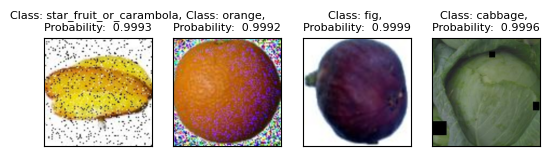

In [39]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

NUM_IMG = 4
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()
    
    classes.append(
        {"class": idx_to_class[np.argmax(probas[0])],
         "proba": np.max(probas[0])})

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.set_title(f'Class: {classes[i]["class"]}, \nProbability:  {classes[i]["proba"]:.4f}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])


# Own photos

In [40]:
import os
path = "CV_data/own_photos/"
path = "CV_data/own_photos_no_background/"
classes = os.listdir(path)
classes = [fldr for fldr in classes if not fldr.startswith('.')]

print(classes)


transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor()
])


custom_test_dataset = datasets.ImageFolder(root=path, transform=transform)

custom_test_loader = DataLoader(dataset=custom_test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)


['mango', 'banana', 'apple', 'bell_pepper', 'strawberry', 'cucumber']


In [41]:
import cv2
import numpy as np

In [42]:
def extract_object(image_batch):
    processed_images = []
    for image in image_batch:
        image = np.clip(image, 0, 1)

        image = (image * 255).byte().numpy()
        image = np.transpose(image, (1, 2, 0))

        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
        thresh = thresh.astype(np.uint8)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            max_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(max_contour)

            max_size = max(w, h)
            if w % 2 == 1:
                w = w - 1
            if h % 2 == 1:
                h = h - 1

            if w < h:
                x0_new = int(x+w/2-h/2)
                x1_new = int(x+w/2+h/2)
                if x0_new < 0:
                    x1_new -= x0_new
                    x0_new = 0
                elif x1_new > RESOLUTION:
                    x0_new -= (x1_new - RESOLUTION)
                    x1_new = RESOLUTION
                image = image[y:y+h, x0_new:x1_new]
            elif w == h:
                image = image[y:y+h, x:x+w]
            else:
                y0_new = int(y+h/2-w/2)
                y1_new = int(y+h/2+w/2)
                if y0_new < 0:
                    y1_new -= y0_new
                    y0_new = 0
                elif y1_new > RESOLUTION:
                    y0_new -= (y1_new - RESOLUTION)
                    y1_new = RESOLUTION
                image = image[y0_new:y1_new, x:x+w]

            image = np.transpose(image, (2, 0, 1))

            image = torch.from_numpy(image)
            transform = transforms.Resize(RESOLUTION)
            image = transform(image)

            processed_images.append(image)
        else:
            image = np.transpose(image, (2, 0, 1))

            processed_images.append(image)

    processed_images = torch.stack(processed_images).float() / 255.0

    return processed_images

{'class': 'peach', 'proba': 0.8897358}
{'class': 'cherry_black', 'proba': 0.07626901}
{'class': 'potato', 'proba': 0.008854855}
{'class': 'apple', 'proba': 0.008654114}
{'class': 'onion', 'proba': 0.0044760555}


{'class': 'chilli_pepper', 'proba': 0.8293755}
{'class': 'eggplant', 'proba': 0.16860667}
{'class': 'banana', 'proba': 0.0011567982}
{'class': 'corn', 'proba': 0.0001478867}
{'class': 'onion', 'proba': 0.00014270071}


{'class': 'grapes', 'proba': 0.878911}
{'class': 'peach', 'proba': 0.081534185}
{'class': 'apple', 'proba': 0.030352162}
{'class': 'cherry_black', 'proba': 0.0028445083}
{'class': 'nectarine', 'proba': 0.0028248425}


{'class': 'apple', 'proba': 0.612379}
{'class': 'pear', 'proba': 0.25044793}
{'class': 'grapes', 'proba': 0.052903846}
{'class': 'corn', 'proba': 0.011987398}
{'class': 'bell_pepper', 'proba': 0.008979182}


{'class': 'grapes', 'proba': 0.9998479}
{'class': 'cherry_black', 'proba': 2.0546e-05}
{'class': 'apple', 'proba': 1.6933041e-05}
{'class': 'p

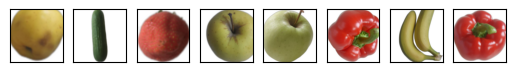

In [43]:
for batch_idx, (features, targets) in enumerate(custom_test_loader):

    features = features
    targets = targets
    break

features = extract_object(features)
    
NUM_IMG = 8
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    proba_indices = np.argsort(probas[0])[::-1][:5]  # Get indices of top 5 classes
    top_classes = [{"class": idx_to_class[idx], "proba": probas[0][idx]} for idx in proba_indices]
    classes.extend(top_classes)

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
    ax.set_xticks([])
    ax.set_yticks([])

for i, c in enumerate(classes):
    print(c)
    if ((i + 1) % 5) == 0:
        print('\n')

In [36]:
# Checking the dataset
for images, labels in custom_test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Labels:', labels)
    break

Image batch dimensions: torch.Size([29, 3, 200, 200])
Image label dimensions: torch.Size([29])
Labels: tensor([0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 4, 2, 0, 5, 1, 0, 5, 0, 2, 4, 1, 0, 1, 3,
        5, 2, 2, 3, 0])


In [37]:
from lib.nutrifacts import retrieve_nutrition_facts
import json

from IPython.core.display import HTML
HTML("&micro;")

print(json.dumps(retrieve_nutrition_facts(classes[2]["class"]), indent=4))

{'Food_Group': 'Fruits', 'Food Name': 'Carambola', 'Energy(kcal)': 37, 'Water(g)': '91,4', 'Protein(g)': '0,5', 'Fat(g)': '0,3', 'Fatty_acids_total(g)': '0,2', 'Fatty acids saturated total(g)': '0,1', 'Carbohydrate(g)': '7,2', 'Sugar(g)': '7,1', 'Starch(g)': '0,2', 'Fiber dietary total(g)': '1,7', 'Na(mg)': 2.0, 'K(mg)': 150.0, 'Ca(mg)': 5.0, 'P(mg)': 15.0, 'Mg(mg)': 6.0, 'Fe(mg)': '0,6', 'Cu(mg)': '0,12', 'Se(µg)': 1.0, 'Zn(mg)': '0,1', 'Id(µg)': nan, 'Vitamin_D(µg)': '0', 'Vitamin_E(mg)': '0,2', 'Vitamin_K(µg)': '0', 'Vitamin_B1(mg)': '0,03', 'Vitamin_B2(mg)': '0,03', 'Vitamin_B6(mg)': '0,017', 'Vitamin_B12(µg)': '0', 'Vitamin_B3(mg)': '0,4', 'Vitamin_C(mg)': 31.0, 'Vitamin_A': 58.0}
{
    "Food Name": "Carambola",
    "Energy(kcal)": 37,
    "Water(g)": 91.4,
    "Protein(g)": 0.5,
    "Fat(g)": 0.3,
    "Fatty_acids_total(g)": 0.2,
    "Fatty acids saturated total(g)": 0.1,
    "Carbohydrate(g)": 7.2,
    "Sugar(g)": 7.1,
    "Starch(g)": 0.2,
    "Fiber dietary total(g)": 1.7,
   